# Springboard Capstone 2: 
## Covid-19 Wastewater Surveillance Prediction
### Author: Nantawat Samermit

## Executive Summary

### Problem:
The Sars-CoV-19 or 'Covid-19' virus is an ongoing pandemic. Businesses and communities are being affected with each wave. Wastewater surveillance is a non-invasive way to measure mRNA concentrations of the virus.

### Exploratory Research Question:
Can we use the viral concentration surveilled from wastewater to predict a surge?


### Methods
    Rationale for Method

### Results

### Implications

# Data Scraping (Unit 7.2)
I'll be scraping two datasets. 

The first is from the Cambridge MA wastewater data archive. It is listed as JSON, which I will convert to a pandas DataFrame. 

The URL is here: 'https://data.cambridgema.gov/resource/ayt4-g2ye.json'


This is the dataset by which I will train and test my model.
The second will be the statewide Massachusetts data. This dataset is where I will test my final model.

The URL is here: 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

In [1]:
#import relevant modules for data wrangling - keep on adding as needed
import pandas as pd
import json, requests
import fuzzywuzzy 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

## Notes regarding Massachusetts Data
After some attempts, it seems the Massachusetts dataset is a multi-page csv, and it isn't easily accessible.

I will have to use BeautifulSoup to isolate the link to the excel file.

In [2]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

In [3]:
# Use BS to identify/isolate the html "class" pointing to the href of the .xls 
#class and "ma__download-link__file-link" was identified by inspecting the page's elements in chrome
source = requests.get("https://www.mass.gov/doc/covid-19-raw-data-june-15-2021")
BeautifulSoup(source.content).find("a", {"class":"ma__download-link__file-link"}).get("href")

'/doc/covid-19-raw-data-june-15-2021/download'

BeautifulSoup has isloated the href link for the .xls spreadsheet. 

It is here: https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download

## Scrape, Download, and Save datasets
I will write a function to scrape, convert, and save both datasets to my directory as pickle files. 

In [4]:
#Luka states it is easier (and acceptable) to just download the files to local path. 

#For the mass.gov dataset, it has mulitiple sheets, so it isolates the intended sheet. (not dynamic, ikr)

def get_sources(source_list):
    '''
    this function takes a list of urls, ID's their format, requests dataset from source,
    converts data into a dataframe, then saves it as a pickled file.
    '''
    for source in source_list:
        if source.endswith('.json'):
            response = requests.get(source)
            data = response.json()
            json_df = pd.DataFrame(data)
            json_df.to_pickle('Cambridge.pkl')
            print('Cambridge.pkl created using this source: ', source)
            
        else:
            response = requests.get(source, allow_redirects=True)
            with open('excel_data.xlsx', 'wb') as file:
                file.write(response.content)
            
            #using pd.read_excel on a multi-spreadsheet xls yields a dictionary
            excel_dict = pd.read_excel('excel_data.xlsx', sheet_name=None)
            
            #can ID sheetnames by evaluating keys
            #print(excel_dict.keys())
            
            #Will be using the "Weekly_City_Town" sheet
            Mass_weekly_city = excel_dict['Weekly_City_Town']
            
            #Use df.to_pickle to save as .pkl file
            Mass_weekly_city.to_pickle('Mass_Weekly_City_df.pkl')
            
            print('Mass_Weekly_City.pkl created using this source', source)

In [5]:
sources = ['https://data.cambridgema.gov/resource/ayt4-g2ye.json', 
           'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download']

get_sources(sources)

Cambridge.pkl created using this source:  https://data.cambridgema.gov/resource/ayt4-g2ye.json
Mass_Weekly_City.pkl created using this source https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download


## Use pickle to confirm the saved files can be loaded in Jupyter

In [6]:
import pickle

In [7]:
#should use context manager to load pickles 
# Don't forget to state 'rb' param or will get an Unicode Error.
with open('Cambridge.pkl', 'rb') as f:
    Cambridge_df = pickle.load(f)
    
with open('Mass_Weekly_City_df.pkl', 'rb') as f:
    Mass_df = pickle.load(f)

In [8]:
#testing both dataframes
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          293 non-null    object
 1   mwra_concentration            293 non-null    object
 2   mwra_7dayaverage              293 non-null    object
 3   concentration_mid_cambridge   293 non-null    object
 4   concentration_east_cambridge  293 non-null    object
 5   concentration_cambridgeport   293 non-null    object
 6   concentration_north_west      293 non-null    object
 7   highci_mid_cambridge          293 non-null    object
 8   highci_east_cambridge         293 non-null    object
 9   highci_cambridgeport          293 non-null    object
 10  highci_north_west_cambridge   293 non-null    object
 11  lowci_mid_cambridge           293 non-null    object
 12  lowci_east_cambridge          293 non-null    object
 13  lowci_cambridgeport 

In [9]:
Mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   City/Town                   8800 non-null   object        
 1   County                      8800 non-null   object        
 2   Population                  8800 non-null   object        
 3   Total Case Counts           8800 non-null   object        
 4   Two Week Case Counts        8800 non-null   object        
 5   Average Daily Rate          8800 non-null   object        
 6   Color                       8791 non-null   object        
 7   Change in Last Week         8800 non-null   object        
 8   Total Tests                 8800 non-null   int64         
 9   Total Tests Last Two Weeks  8799 non-null   float64       
 10  Total Positive Tests        8799 non-null   float64       
 11  Percent Positivity          8799 non-null   object      

# Data Wrangling (Unit 7.2)
Explore the dataset. Understand the datatypes for the various columns, and confirm that there are no missing values.

## Cambridge Data

In [10]:
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          293 non-null    object
 1   mwra_concentration            293 non-null    object
 2   mwra_7dayaverage              293 non-null    object
 3   concentration_mid_cambridge   293 non-null    object
 4   concentration_east_cambridge  293 non-null    object
 5   concentration_cambridgeport   293 non-null    object
 6   concentration_north_west      293 non-null    object
 7   highci_mid_cambridge          293 non-null    object
 8   highci_east_cambridge         293 non-null    object
 9   highci_cambridgeport          293 non-null    object
 10  highci_north_west_cambridge   293 non-null    object
 11  lowci_mid_cambridge           293 non-null    object
 12  lowci_east_cambridge          293 non-null    object
 13  lowci_cambridgeport 

In [11]:
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
count,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
unique,293,232,214,30,35,27,34,30,35,27,34,30,35,27,34
top,2021-02-03T00:00:00.000,,20,,,,,,,,,,,,
freq,1,14,6,258,256,260,256,258,256,260,256,258,256,260,256


# Note to myself:
For my own review!

Column Definitions:
Date - sample date for 24 hour composite sample


MWRA_Concentration - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


MWRA_7DayAverage - 7 day rolling average for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


Concentration_* - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


highci_* - Upper Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


lowci_* - Lower Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.
* means there are multiple columns with this prefix which share the same definition - Nantawat

A refresher on confidence interval limits - https://bit.ly/3vtuI7h


## Features observations:
1. All the features pf Cambridge_df are object dtypes.
2. describe() states they (15 features) are all non-null values. Let's confirm that.

In [12]:
#This confirms that none of the features contain null values. 
Cambridge_df.isnull().sum()

date                            0
mwra_concentration              0
mwra_7dayaverage                0
concentration_mid_cambridge     0
concentration_east_cambridge    0
concentration_cambridgeport     0
concentration_north_west        0
highci_mid_cambridge            0
highci_east_cambridge           0
highci_cambridgeport            0
highci_north_west_cambridge     0
lowci_mid_cambridge             0
lowci_east_cambridge            0
lowci_cambridgeport             0
lowci_north_west_cambridge      0
dtype: int64

In [13]:
#This will show that although isnull().sum() returns 0 null values, the cells look blank!
Cambridge_df.head(5)

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
0,2020-10-01T00:00:00.000,,31,,,,,,,,,,,,
1,2020-10-02T00:00:00.000,34,31,,,,,,,,,,,,
2,2020-10-03T00:00:00.000,,31,,,,,,,,,,,,
3,2020-10-04T00:00:00.000,,31,,,,,,,,,,,,
4,2020-10-05T00:00:00.000,38,30,,,,,,,,,,,,


### This does not pass the stench test! mwra_concentration is not 100% non-null

In [14]:
#Check these blank cells to confirm they are 'filled' with whitespaces
Cambridge_df['mwra_concentration'][0] == ''

True

In [15]:
#create a method using the logic from the cell above to check for blank cells
def blank_check(df):
    ''' A method to check my column cells from a pandas DataFrame for whitespace blanks.'''
    return dict(zip(df.columns, [(df[x] == '').sum() for x in df.columns]))

In [16]:
blank_check(Cambridge_df)

{'date': 0,
 'mwra_concentration': 14,
 'mwra_7dayaverage': 4,
 'concentration_mid_cambridge': 258,
 'concentration_east_cambridge': 256,
 'concentration_cambridgeport': 260,
 'concentration_north_west': 256,
 'highci_mid_cambridge': 258,
 'highci_east_cambridge': 256,
 'highci_cambridgeport': 260,
 'highci_north_west_cambridge': 256,
 'lowci_mid_cambridge': 258,
 'lowci_east_cambridge': 256,
 'lowci_cambridgeport': 260,
 'lowci_north_west_cambridge': 256}

### Looking at how many 'blank' whitespace cells those features have, I think it is prudent to drop them first

In [17]:
kept_features = ['date', 'mwra_concentration', 'mwra_7dayaverage']
Cambridge_df.drop(columns=Cambridge_df.columns.difference(kept_features), inplace=True)

In [18]:
#confirm those columns were dropped
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage
count,293,293,293
unique,293,232,214
top,2021-02-03T00:00:00.000,,20
freq,1,14,6


In [19]:
#confirm how many blank cells to wrangle
blank_check(Cambridge_df)

{'date': 0, 'mwra_concentration': 14, 'mwra_7dayaverage': 4}

### At this point - Choose:
1. Drop those rows with blank columns
2. Impute them with something
    
    A: Can be the mwra_7dayaverage
    
    B: Can be a front-fill method    
    
    C:  Can be a back-fill method

#### I chose option 2, and I want to fill with the mwra_7dayaverage where I can. 

In [20]:
#change 'date' feature into a datetime and assign to index
Cambridge_df.date = pd.to_datetime(Cambridge_df.date)
Cambridge_df.set_index('date', inplace=True)

In [21]:
#blank check before the whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 14, 'mwra_7dayaverage': 4}

In [22]:
#replace whitespace with NaN and check for an decrease in blank_check and increase in null
#The increase seen with .isnull() is due to us replacing '' with 
Cambridge_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [23]:
#blank check after whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 0, 'mwra_7dayaverage': 0}

In [24]:
Cambridge_df.isnull().sum()

mwra_concentration    14
mwra_7dayaverage       4
dtype: int64

#### This passes the stench test now, and we can easily deal with NaNs.

In [25]:
#replace mwra_7dayaverage NaNs with .replace() and frontfill method
Cambridge_df.mwra_7dayaverage.replace(np.nan, method='ffill', inplace=True)

#replace mwra_concentration NaNs with the given mwra_7dayaverage using .fillna()
Cambridge_df.mwra_concentration.fillna(Cambridge_df.mwra_7dayaverage, inplace=True)

Cambridge_df.isnull().sum()

mwra_concentration    0
mwra_7dayaverage      0
dtype: int64

In [26]:
Cambridge_cleaned = Cambridge_df.copy()

## Masschusetts Data

In [27]:
Mass_df.shape

(8800, 17)

In [28]:
Mass_df.columns

Index(['City/Town', 'County', 'Population', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate', 'Report Date', 'Start_Date', 'End_Date'],
      dtype='object')

In [29]:
#I am only interested in the Cambridge city data.
Cambridge_weekly_trend = Mass_df[Mass_df['City/Town'] == 'Cambridge']

In [30]:
Cambridge_weekly_trend.shape

(25, 17)

In [31]:
Cambridge_weekly_trend.isnull().sum()

City/Town                     0
County                        0
Population                    0
Total Case Counts             0
Two Week Case Counts          0
Average Daily Rate            0
Color                         0
Change in Last Week           0
Total Tests                   0
Total Tests Last Two Weeks    0
Total Positive Tests          0
Percent Positivity            0
Change Since Last Week        0
Testing Rate                  0
Report Date                   0
Start_Date                    0
End_Date                      0
dtype: int64

In [32]:
blank_check(Cambridge_weekly_trend)

{'City/Town': 0,
 'County': 0,
 'Population': 0,
 'Total Case Counts': 0,
 'Two Week Case Counts': 0,
 'Average Daily Rate': 0,
 'Color': 0,
 'Change in Last Week': 0,
 'Total Tests': 0,
 'Total Tests Last Two Weeks': 0,
 'Total Positive Tests': 0,
 'Percent Positivity': 0,
 'Change Since Last Week': 0,
 'Testing Rate': 0,
 'Report Date': 0,
 'Start_Date': 0,
 'End_Date': 0}

#### No stenches here. Let's look at the features and determine what we should keep.

In [33]:
#dropping index of Cambridge_weekly_trend
Cambridge_weekly_trend.reset_index(drop=True, inplace=True)

In [34]:
Cambridge_weekly_trend.columns

Index(['City/Town', 'County', 'Population', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate', 'Report Date', 'Start_Date', 'End_Date'],
      dtype='object')

In [35]:
#confirming these columns are datetime types
date_columns = ['Report Date', 'Start_Date', 'End_Date']
Cambridge_weekly_trend[
    [col for col in Cambridge_weekly_trend[date_columns]]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Report Date  25 non-null     datetime64[ns]
 1   Start_Date   25 non-null     datetime64[ns]
 2   End_Date     25 non-null     datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 728.0 bytes


In [36]:
#Since I am merging on 'per' below, may not need to set the index to date this early here. 
#I was wrong, I do need this early or else I can't use .to_period() down below for Cambridge_weekly_trend
Cambridge_weekly_trend.set_index('Report Date', drop=True, inplace=True)

#### I've decided to drop columns after I merge the two datasets.

### Even though this is a larger dataset (and may take more computation cycles), I feel more comfortable using .copy() when testing out new things

In [37]:
test_df = Cambridge_cleaned.copy()

### There are some common date ranges we can merge on. I will covert the most appropriate datetime Series into 'periods' and merge on them.

In [38]:
#remember the index was the original 'date' column converted to datetime
test_df['per'] = test_df.index.to_period('w')

In [39]:
#This will throw a warning, but the code runs in my Jupyter environment. 
Cambridge_weekly_trend['per'] = Cambridge_weekly_trend.index.to_period('w')

<ipython-input-39-c79ecc60218b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cambridge_weekly_trend['per'] = Cambridge_weekly_trend.index.to_period('w')


### Merge the datasets on the 'per' column and do a final inspection

In [40]:
merged_df = test_df.reset_index().merge(Cambridge_weekly_trend, on='per')

In [41]:
merged_df.shape

(175, 20)

In [42]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        175 non-null    datetime64[ns]
 1   mwra_concentration          175 non-null    object        
 2   mwra_7dayaverage            175 non-null    object        
 3   per                         175 non-null    period[W-SUN] 
 4   City/Town                   175 non-null    object        
 5   County                      175 non-null    object        
 6   Population                  175 non-null    object        
 7   Total Case Counts           175 non-null    object        
 8   Two Week Case Counts        175 non-null    object        
 9   Average Daily Rate          175 non-null    object        
 10  Color                       175 non-null    object        
 11  Change in Last Week         175 non-null    object        

### After review, will drop columns with the same values (only 1 unique value), and other datetime64 populated columns other than date. Will also drop the 'per' column as the merged occured already.

In [43]:
merged_df['City/Town'].nunique() #drop

1

In [44]:
merged_df['Population'].nunique() #drop

1

In [45]:
merged_df['County'].nunique() #drop

1

In [46]:
drop_list = ['City/Town', 'County', 'Population', 'per', 'Start_Date', 'End_Date']

#list comp of all the columns I will keep for the final dataframe
kept_merged_features = [x for x in merged_df.columns if x not in drop_list]
kept_merged_features

['date',
 'mwra_concentration',
 'mwra_7dayaverage',
 'Total Case Counts',
 'Two Week Case Counts',
 'Average Daily Rate',
 'Color',
 'Change in Last Week',
 'Total Tests',
 'Total Tests Last Two Weeks',
 'Total Positive Tests',
 'Percent Positivity',
 'Change Since Last Week',
 'Testing Rate']

In [47]:
cleaned_df = merged_df.drop(columns=merged_df.columns.difference(kept_merged_features), inplace=False)

In [48]:
cleaned_df[::30]

,date,mwra_concentration,mwra_7dayaverage,Total Case Counts,Two Week Case Counts,Average Daily Rate,Color,Change in Last Week,Total Tests,Total Tests Last Two Weeks,Total Positive Tests,Percent Positivity,Change Since Last Week,Testing Rate
0,2020-12-21,775,775,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
30,2021-01-20,422,721,3618,554,35.335095,Yellow,Higher,494699,44470.0,663.0,0.014909,Lower,39709.248618
60,2021-02-19,579,279,4271,228,14.542241,Yellow,Lower,603952,55154.0,290.0,0.005258,Lower,49249.469267
90,2021-03-21,227,288,4734,256,16.328131,Yellow,Lower,733535,66767.0,301.0,0.004508,No Change,59619.235496
120,2021-04-20,131,207,5527,314,20.027473,Yellow,Lower,897975,64183.0,382.0,0.005952,No Change,57311.866518
150,2021-05-20,57,42,5713,47,2.997743,Green,Lower,1012048,54831.0,63.0,0.001149,No Change,48961.048144


In [49]:
blank_check(cleaned_df), cleaned_df.isnull().sum()

({'date': 0,
  'mwra_concentration': 0,
  'mwra_7dayaverage': 0,
  'Total Case Counts': 0,
  'Two Week Case Counts': 0,
  'Average Daily Rate': 0,
  'Color': 0,
  'Change in Last Week': 0,
  'Total Tests': 0,
  'Total Tests Last Two Weeks': 0,
  'Total Positive Tests': 0,
  'Percent Positivity': 0,
  'Change Since Last Week': 0,
  'Testing Rate': 0},
 date                          0
 mwra_concentration            0
 mwra_7dayaverage              0
 Total Case Counts             0
 Two Week Case Counts          0
 Average Daily Rate            0
 Color                         0
 Change in Last Week           0
 Total Tests                   0
 Total Tests Last Two Weeks    0
 Total Positive Tests          0
 Percent Positivity            0
 Change Since Last Week        0
 Testing Rate                  0
 dtype: int64)

#### Setting the index to be the date feature, and dropping that column.

In [50]:
cleaned_df.set_index(cleaned_df.date, inplace=True)
cleaned_df.drop(columns=['date'], inplace=True)
cleaned_df

,mwra_concentration,mwra_7dayaverage,Total Case Counts,Two Week Case Counts,Average Daily Rate,Color,Change in Last Week,Total Tests,Total Tests Last Two Weeks,Total Positive Tests,Percent Positivity,Change Since Last Week,Testing Rate
date,,,,,,,,,,,,,
2020-12-21,775,775,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-22,995,974,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-23,841,968,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-24,985,952,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-25,907,932,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09,14,22,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-10,33,23,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-11,40,25,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843


## Note about this merged dataframe:
1. I think this is considered an inner merge. Based on the 'per' column.
2. Inner Join imputed the many features from the Mass_df to Cambridge.
3. Ready for EDA 7.26.21 NS

In [51]:
#Some summary statistics
cleaned_df.describe(), cleaned_df.shape

(        Total Tests  Total Tests Last Two Weeks  Total Positive Tests
 count  1.750000e+02                   175.00000             175.00000
 mean   7.385826e+05                 53117.44000             330.80000
 std    2.114221e+05                 11891.94666             182.37296
 min    4.243990e+05                 27189.00000              31.00000
 25%    5.491970e+05                 44470.00000             230.00000
 50%    7.335350e+05                 55154.00000             301.00000
 75%    9.280730e+05                 64183.00000             479.00000
 max    1.063577e+06                 67166.00000             663.00000,
 (175, 13))

### At every Unit submission, I will create a new pickle file.

In [ ]:
#cleaned_df.to_pickle('Unit11EDA.pkl') #Created 7.27.21 NS and commented out for Github submission

# Exploratory Data Analysis (Unit 11.5)

### Goal from the rubric:
1. Investigate every feature using histograms, bi-plots, or other visual and numeric means
2. Pearson correlation coefficients and other statistical methods were used to ID statistical relationship strengths

In [52]:
with open('Unit11EDA.pkl', 'rb') as f:
    df = pickle.load(f)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2020-12-21 to 2021-06-13
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mwra_concentration          175 non-null    object 
 1   mwra_7dayaverage            175 non-null    object 
 2   Total Case Counts           175 non-null    object 
 3   Two Week Case Counts        175 non-null    object 
 4   Average Daily Rate          175 non-null    object 
 5   Color                       175 non-null    object 
 6   Change in Last Week         175 non-null    object 
 7   Total Tests                 175 non-null    int64  
 8   Total Tests Last Two Weeks  175 non-null    float64
 9   Total Positive Tests        175 non-null    float64
 10  Percent Positivity          175 non-null    object 
 11  Change Since Last Week      175 non-null    object 
 12  Testing Rate                175 non-null    object 
dtypes: float64(2), i

### The types of the features may be problematic when trying to run statistical analysis. Let's see what types they should be, and then do the proper vectorized conversion.

In [54]:
#As always, I use copy when doing any testing
test = df.copy()

In [55]:
test.columns

Index(['mwra_concentration', 'mwra_7dayaverage', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate'],
      dtype='object')

In [56]:
test.head(5)

,mwra_concentration,mwra_7dayaverage,Total Case Counts,Two Week Case Counts,Average Daily Rate,Color,Change in Last Week,Total Tests,Total Tests Last Two Weeks,Total Positive Tests,Percent Positivity,Change Since Last Week,Testing Rate
date,,,,,,,,,,,,,
2020-12-21,775,775,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-22,995,974,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-23,841,968,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-24,985,952,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981
2020-12-25,907,932,2645,421,26.852121,Yellow,Lower,424399,42729.0,505.0,0.011819,No Change,38154.631981


In [57]:
test.tail(5)

,mwra_concentration,mwra_7dayaverage,Total Case Counts,Two Week Case Counts,Average Daily Rate,Color,Change in Last Week,Total Tests,Total Tests Last Two Weeks,Total Positive Tests,Percent Positivity,Change Since Last Week,Testing Rate
date,,,,,,,,,,,,,
2021-06-09,14,22,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-10,33,23,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-11,40,25,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-12,32,25,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843
2021-06-13,20,24,5758,27,1.722108,Green,Lower,1063577,33174.0,31.0,0.000934,No Change,29622.545843


### Here's how I think they should be converted
1. Int64 = ['mwra_concetration', 'mwra_7dayaverage', 'Total Case Counts', 'Two Week Case Counts', 'Total Tests', 'Total Positive Tests']
2. Category = ['Color', 'Change in Last Week', 'Change Since Last Week']
3. Float64 = ['Average Daily Rate', 'Total Tests Last Two Weeks', 'Percent Positivity', 'Testing Rate']

Will create a unit test first.

In [58]:
int64_list = ['mwra_concentration', 'mwra_7dayaverage', 'Total Case Counts', 'Two Week Case Counts',
              'Total Tests', 'Total Positive Tests']

category_list = ['Color', 'Change in Last Week', 'Change Since Last Week']

float64_list = ['Average Daily Rate', 'Total Tests Last Two Weeks', 'Percent Positivity',
                'Testing Rate']
conversion_list = [int64_list, category_list, float64_list]

In [59]:
#Unit testing my conversion loop logic
for list in conversion_list:
    print(list)
    for col in list:
        if col in int64_list:
            print('Will convert these to int64: ', col)
        if col in category_list:
            print('Will convert these to category: ',col)
        if col in float64_list:
            print('Will convert these to float64: ', col)

['mwra_concentration', 'mwra_7dayaverage', 'Total Case Counts', 'Two Week Case Counts', 'Total Tests', 'Total Positive Tests']
Will convert these to int64:  mwra_concentration
Will convert these to int64:  mwra_7dayaverage
Will convert these to int64:  Total Case Counts
Will convert these to int64:  Two Week Case Counts
Will convert these to int64:  Total Tests
Will convert these to int64:  Total Positive Tests
['Color', 'Change in Last Week', 'Change Since Last Week']
Will convert these to category:  Color
Will convert these to category:  Change in Last Week
Will convert these to category:  Change Since Last Week
['Average Daily Rate', 'Total Tests Last Two Weeks', 'Percent Positivity', 'Testing Rate']
Will convert these to float64:  Average Daily Rate
Will convert these to float64:  Total Tests Last Two Weeks
Will convert these to float64:  Percent Positivity
Will convert these to float64:  Testing Rate


In [60]:
for list in conversion_list:
    for col in list:
        if col in int64_list:
            test[col] = test[col].astype('int64')
            #print('These should be converted to int64: ', col)
        if col in category_list:
            test[col] = test[col].astype('category')
            #print('These should be converted to categories: ', col)
        if col in float64_list:
            test[col] = test[col].astype('float64')
            #print('These should be converted to float64: ', col)


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2020-12-21 to 2021-06-13
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   mwra_concentration          175 non-null    int64   
 1   mwra_7dayaverage            175 non-null    int64   
 2   Total Case Counts           175 non-null    int64   
 3   Two Week Case Counts        175 non-null    int64   
 4   Average Daily Rate          175 non-null    float64 
 5   Color                       175 non-null    category
 6   Change in Last Week         175 non-null    category
 7   Total Tests                 175 non-null    int64   
 8   Total Tests Last Two Weeks  175 non-null    float64 
 9   Total Positive Tests        175 non-null    int64   
 10  Percent Positivity          175 non-null    float64 
 11  Change Since Last Week      175 non-null    category
 12  Testing Rate                175 non-null    float64 
dtypes

### Conversion unit test passes, convert all features in df

In [62]:
def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in int64_list:
                df[col] = df[col].astype('int64')
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')

In [63]:
#Pre-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2020-12-21 to 2021-06-13
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mwra_concentration          175 non-null    object 
 1   mwra_7dayaverage            175 non-null    object 
 2   Total Case Counts           175 non-null    object 
 3   Two Week Case Counts        175 non-null    object 
 4   Average Daily Rate          175 non-null    object 
 5   Color                       175 non-null    object 
 6   Change in Last Week         175 non-null    object 
 7   Total Tests                 175 non-null    int64  
 8   Total Tests Last Two Weeks  175 non-null    float64
 9   Total Positive Tests        175 non-null    float64
 10  Percent Positivity          175 non-null    object 
 11  Change Since Last Week      175 non-null    object 
 12  Testing Rate                175 non-null    object 
dtypes: float64(2), i

In [64]:
conversion(df, conversion_list)

In [65]:
#Post-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2020-12-21 to 2021-06-13
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   mwra_concentration          175 non-null    int64   
 1   mwra_7dayaverage            175 non-null    int64   
 2   Total Case Counts           175 non-null    int64   
 3   Two Week Case Counts        175 non-null    int64   
 4   Average Daily Rate          175 non-null    float64 
 5   Color                       175 non-null    category
 6   Change in Last Week         175 non-null    category
 7   Total Tests                 175 non-null    int64   
 8   Total Tests Last Two Weeks  175 non-null    float64 
 9   Total Positive Tests        175 non-null    int64   
 10  Percent Positivity          175 non-null    float64 
 11  Change Since Last Week      175 non-null    category
 12  Testing Rate                175 non-null    float64 
dtypes

### Dtypes have been converted to the intended type, let's do some Exploratory Data Analysis!

<AxesSubplot:>

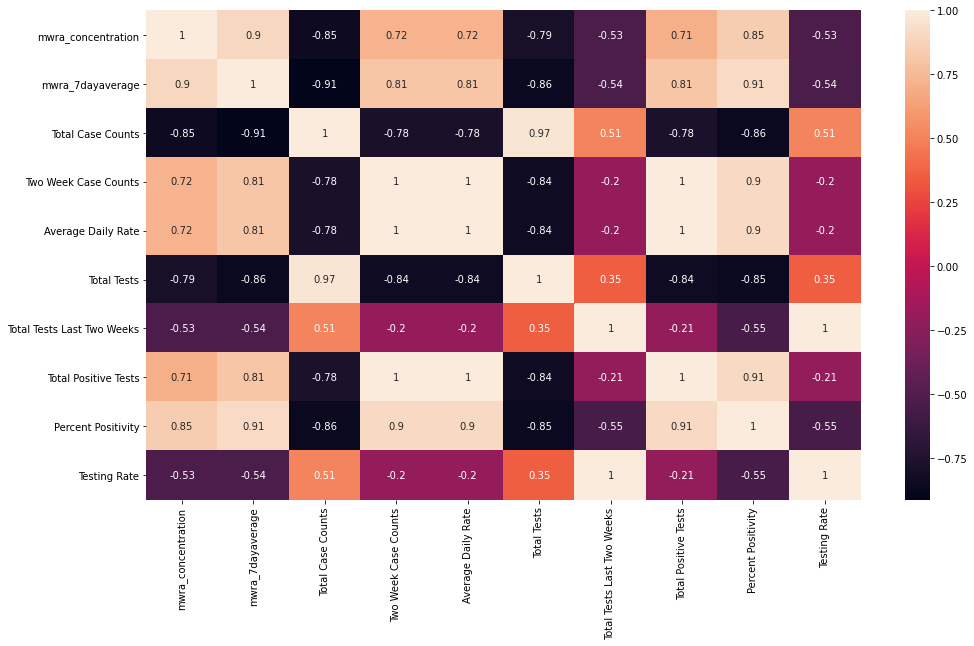

In [66]:
plt.figure(figsize = (16,9))
sns.heatmap(df.corr(), annot=True)

The heatmap is a great visual tool, as it looks at all the non-categorical data, and with the right parameters even annotates their Pearson r value.

In [67]:
#If I didn't want that great visualization...
df.corr()

,mwra_concentration,mwra_7dayaverage,Total Case Counts,Two Week Case Counts,Average Daily Rate,Total Tests,Total Tests Last Two Weeks,Total Positive Tests,Percent Positivity,Testing Rate
mwra_concentration,1.000000,0.902515,-0.848512,0.717756,0.717756,-0.790691,-0.525887,0.708017,0.847631,-0.525887
mwra_7dayaverage,0.902515,1.000000,-0.912432,0.812524,0.812524,-0.857633,-0.537141,0.806769,0.912047,-0.537141
Total Case Counts,-0.848512,-0.912432,1.000000,-0.781040,-0.781040,0.969796,0.511766,-0.776544,-0.863802,0.511766
Two Week Case Counts,0.717756,0.812524,-0.781040,1.000000,1.000000,-0.843726,-0.198852,0.996875,0.904745,-0.198852
Average Daily Rate,0.717756,0.812524,-0.781040,1.000000,1.000000,-0.843726,-0.198852,0.996875,0.904745,-0.198852
Total Tests,-0.790691,-0.857633,0.969796,-0.843726,-0.843726,1.000000,0.354402,-0.841430,-0.854005,0.354402
Total Tests Last Two Weeks,-0.525887,-0.537141,0.511766,-0.198852,-0.198852,0.354402,1.000000,-0.207075,-0.547539,1.000000
Total Positive Tests,0.708017,0.806769,-0.776544,0.996875,0.996875,-0.841430,-0.207075,1.000000,0.905930,-0.207075
Percent Positivity,0.847631,0.912047,-0.863802,0.904745,0.904745,-0.854005,-0.547539,0.905930,1.000000,-0.547539
Testing Rate,-0.525887,-0.537141,0.511766,-0.198852,-0.198852,0.354402,1.000000,-0.207075,-0.547539,1.000000


There is a fairly strong positive correlation (0.84761) between mwra_concentration and Percent Positivity. Another strong correlation is between concentration and Average Daily Rate (0.717756).

These may be worth checking out.

### Using graphs can be a powerful tool to gain insight into the relationship between features.

Text(0.5, 1.0, 'Percent Positivity')

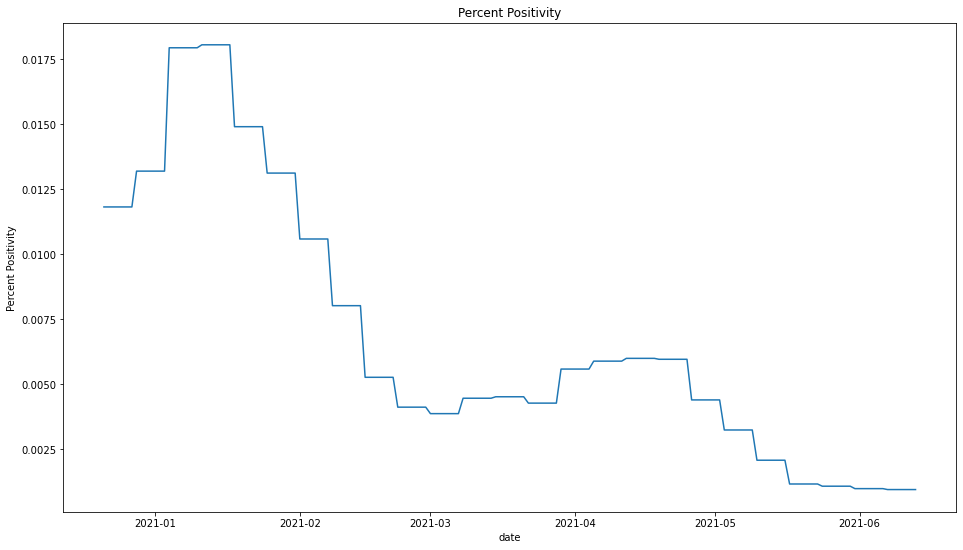

In [68]:
plt.figure(figsize=(16,9))
sns.lineplot(y='Percent Positivity', x=df.index, data=df)
plt.title('Percent Positivity')

Text(0.5, 1.0, 'MWRA Concentration')

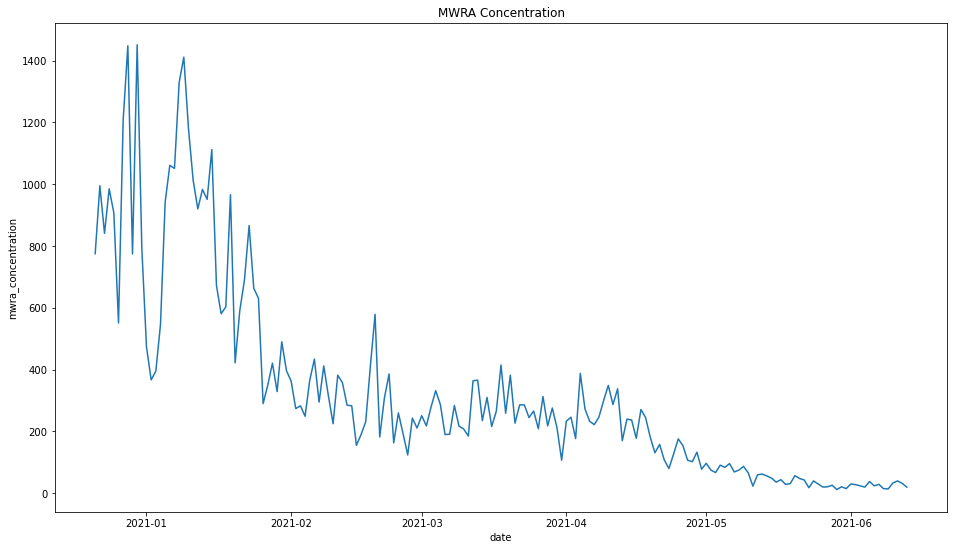

In [69]:
plt.figure(figsize=(16,9))
sns.lineplot(y='mwra_concentration', x=df.index, data=df)
plt.title('MWRA Concentration')

Text(0.5, 1.0, 'Average Daily Rate')

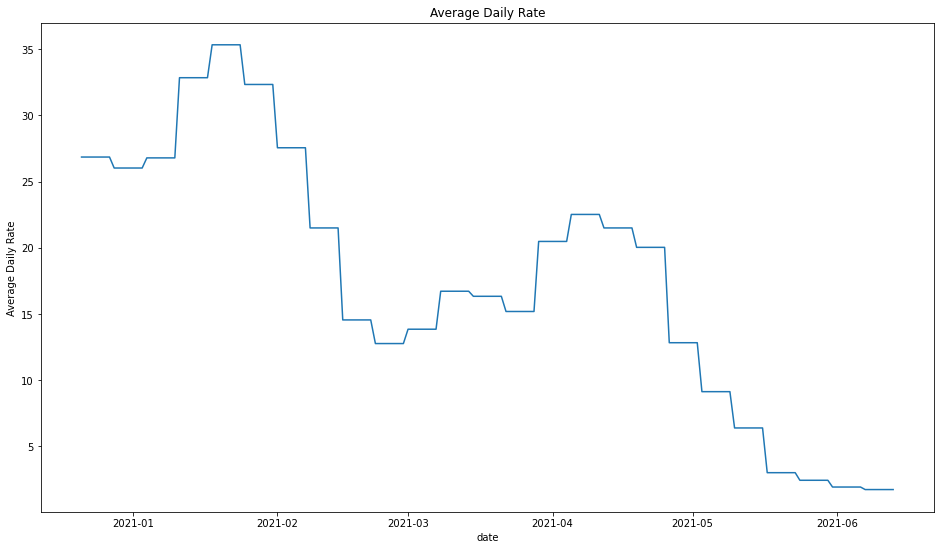

In [70]:
plt.figure(figsize=(16,9))
sns.lineplot(y='Average Daily Rate', x=df.index, data=df)
plt.title('Average Daily Rate')

0.71776

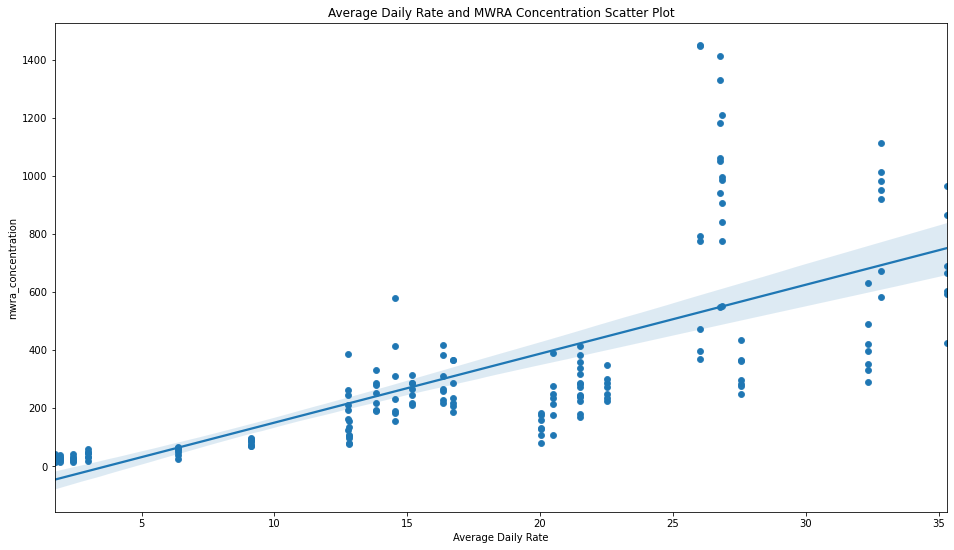

In [71]:
plt.figure(figsize=(16,9))
sns.scatterplot(data = df, x=df['Average Daily Rate'], y=df.mwra_concentration)
sns.regplot(data = df, x=df['Average Daily Rate'], y=df.mwra_concentration)
plt.title('Average Daily Rate and MWRA Concentration Scatter Plot')
df.mwra_concentration.corr(df['Average Daily Rate']).round(5)

0.84763

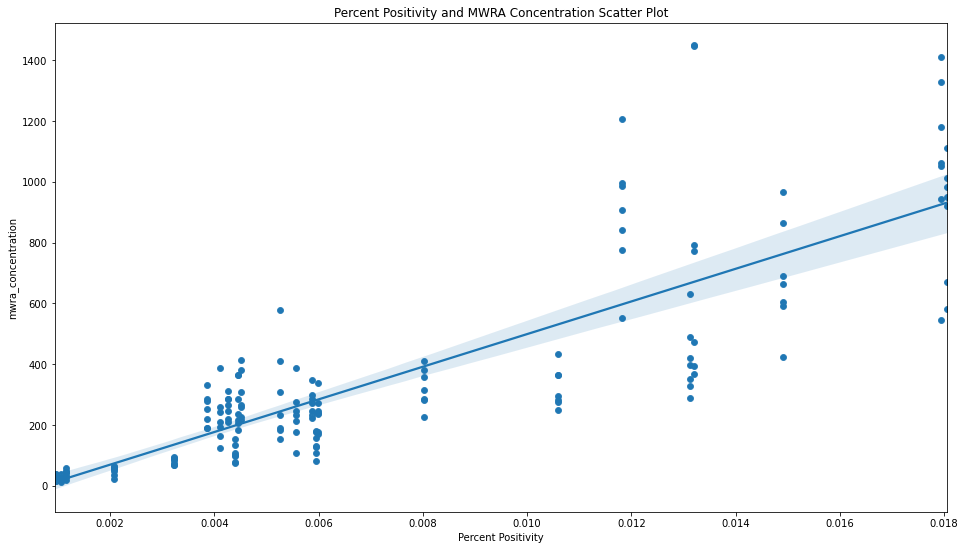

In [72]:
plt.figure(figsize=(16,9))
sns.scatterplot(data = df, x=df['Percent Positivity'], y=df.mwra_concentration)
sns.regplot(data = df, x=df['Percent Positivity'], y=df.mwra_concentration)
plt.title('Percent Positivity and MWRA Concentration Scatter Plot')
df.mwra_concentration.corr(df['Percent Positivity']).round(5)

## Notes to Luka for Review

The three line plots seems to have some kind of time-series trend that are in tandem with each other.

Thoughts on time-series possibilities:
1. AR, MA, or ARMA models
2. Auto-correlation whilst looking at various lag values
3. Probably should test for unit root stationarity.

The scatter plots, while showing large variability, a regression line still showed some positive correlation.

What I worry about is how those outliers seen in the scatterplots may be affecting the calculated correlation coefficients. Must discuss with Luka. 

In [ ]:
#Saving current df for next Capstone 2 Unit
#df.to_pickle('Unit16FeatureEngineering.pkl') #Commenting out for Github commit

# Pre-processing (Unit 16.3)